# MLP
MLP, K=5, epochs=200.
Use lncRNA.
Train set: filter none.
Valid set: filter none.

In [1]:
from datetime import datetime
print(datetime.now())

2023-04-01 21:17:10.980939


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-01 21:17:42.296247
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                65664     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-01 21:17:42.907746
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-04-01 21:18:04.440806

Training # 1 1
2023-04-01 21:18:04.442012
2023-04-01 21:18:04.442079
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-04-01 21:18:04.519833


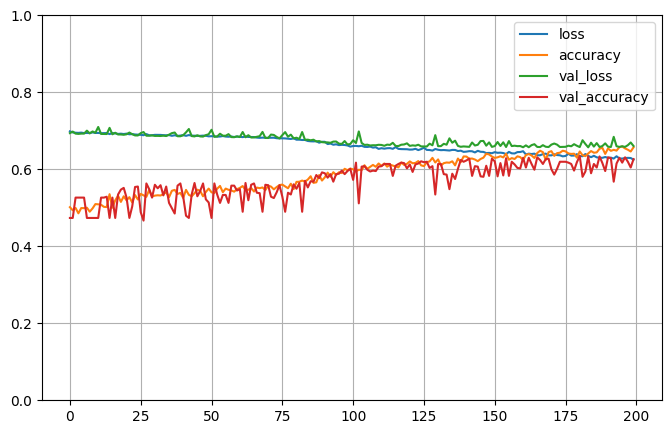


2023-04-01 21:19:28.262085

Testing # 1 1
2023-04-01 21:19:28.262184
2023-04-01 21:19:28.262221
PREDICT
2023-04-01 21:19:28.277561
Test 1:0 458:412 52.64%
Predict 1:0 437:433 50.23%
Test sizes (870, 1025) (870,)
Range of scores: 0.01673522 to 0.949811
Score threshold 0.5
Confusion matrix
 [[260 152]
 [173 285]]
Normalized matrix
 [[0.29885057 0.17471264]
 [0.19885057 0.32758621]]


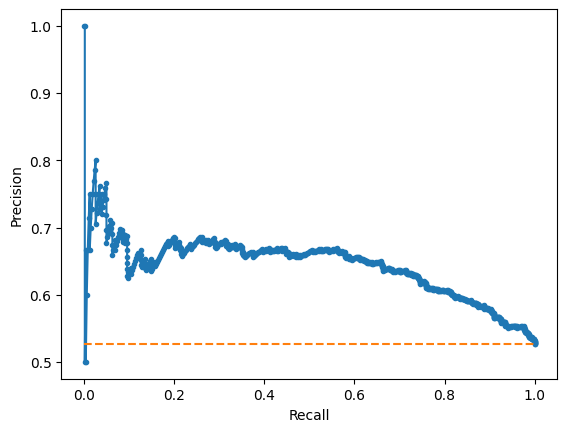

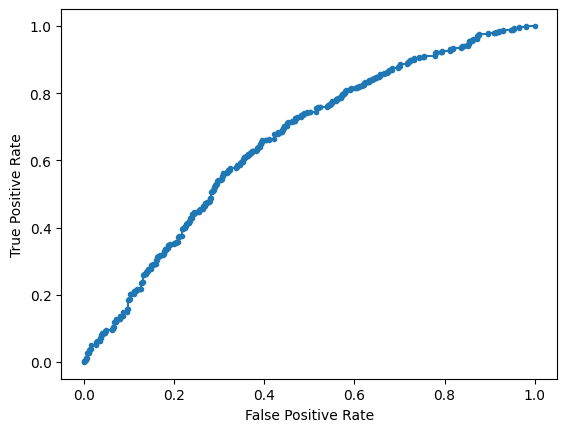

Accuracy: 62.64% Precision: 65.22% Recall: 62.23%
F1: 63.69% MCC: 0.2530
AUPRC: 64.41% AUROC: 65.80%
 accuracy [62.643678160919535]
 precision [65.21739130434783]
 recall [62.227074235807855]
 F1 [63.68715083798882]
 MCC [0.2529870110504406]
 AUPRC [64.41172632422808]
 AUROC [65.80107686437444]
2023-04-01 21:19:29.477418

Training # 1 2
2023-04-01 21:19:29.479764
2023-04-01 21:19:29.480194
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-04-01 21:19:29.593218


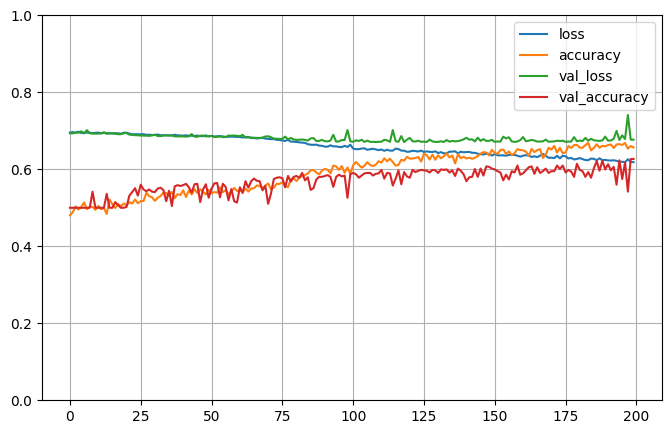


2023-04-01 21:20:46.131227

Testing # 1 2
2023-04-01 21:20:46.131337
2023-04-01 21:20:46.131375
PREDICT
2023-04-01 21:20:46.150484
Test 1:0 442:442 50.00%
Predict 1:0 558:326 63.12%
Test sizes (884, 1025) (884,)
Range of scores: 0.01179963 to 0.98587143
Score threshold 0.5
Confusion matrix
 [[219 223]
 [107 335]]
Normalized matrix
 [[0.24773756 0.25226244]
 [0.12104072 0.37895928]]


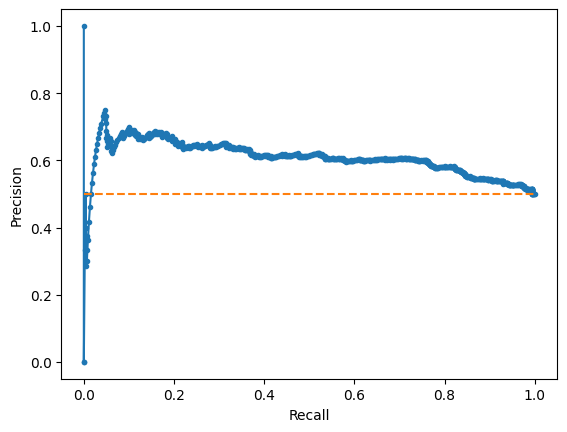

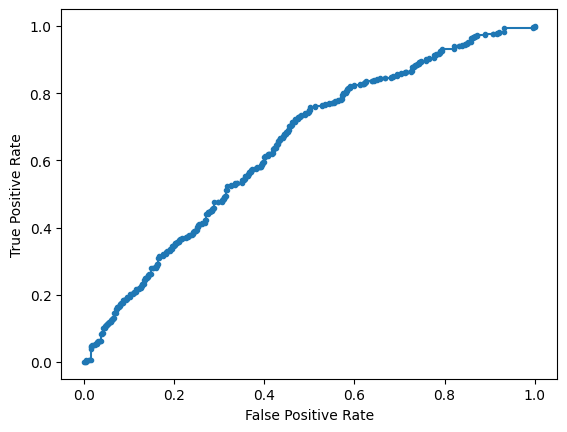

Accuracy: 62.67% Precision: 60.04% Recall: 75.79%
F1: 67.00% MCC: 0.2626
AUPRC: 60.68% AUROC: 64.51%
 accuracy [62.66968325791855]
 precision [60.0358422939068]
 recall [75.7918552036199]
 F1 [67.0]
 MCC [0.26259842874666744]
 AUPRC [60.68103486252194]
 AUROC [64.50727872074692]
2023-04-01 21:20:46.926575

Training # 1 3
2023-04-01 21:20:46.927580
2023-04-01 21:20:46.927640
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-04-01 21:20:47.007017


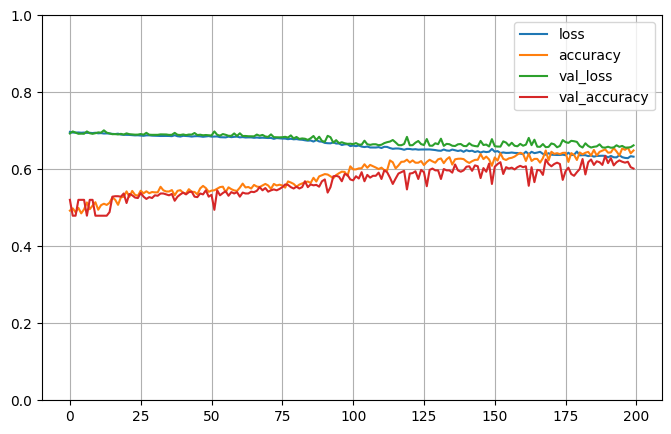


2023-04-01 21:22:00.354576

Testing # 1 3
2023-04-01 21:22:00.354715
2023-04-01 21:22:00.354761
PREDICT
2023-04-01 21:22:00.363797
Test 1:0 442:407 52.06%
Predict 1:0 660:189 77.74%
Test sizes (849, 1025) (849,)
Range of scores: 0.052927144 to 0.95935243
Score threshold 0.5
Confusion matrix
 [[129 278]
 [ 60 382]]
Normalized matrix
 [[0.15194346 0.32744405]
 [0.07067138 0.44994111]]


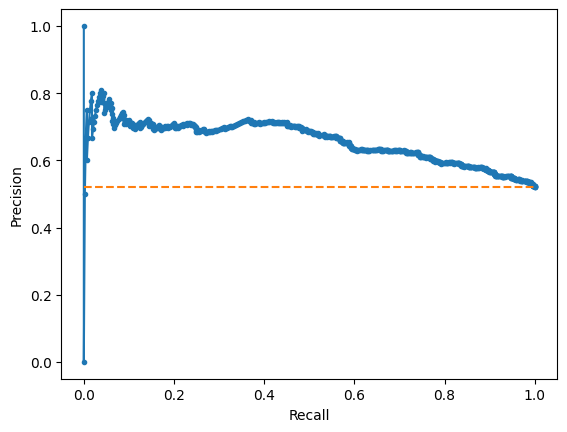

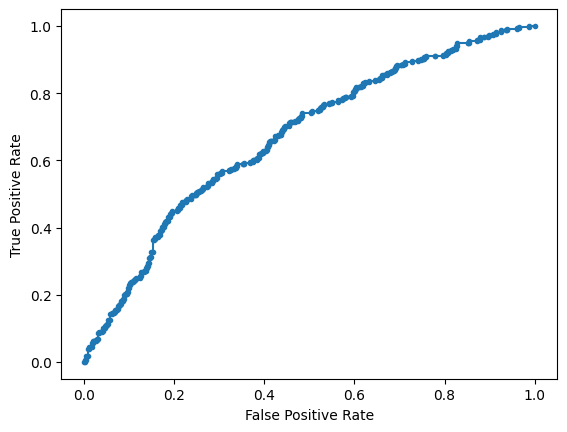

Accuracy: 60.19% Precision: 57.88% Recall: 86.43%
F1: 69.33% MCC: 0.2176
AUPRC: 65.75% AUROC: 66.80%
 accuracy [60.18845700824499]
 precision [57.878787878787875]
 recall [86.42533936651584]
 F1 [69.32849364791288]
 MCC [0.21761044961608636]
 AUPRC [65.75093005723751]
 AUROC [66.80156091920799]
2023-04-01 21:22:01.153238

Training # 1 4
2023-04-01 21:22:01.154289
2023-04-01 21:22:01.154349
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-04-01 21:22:01.234475


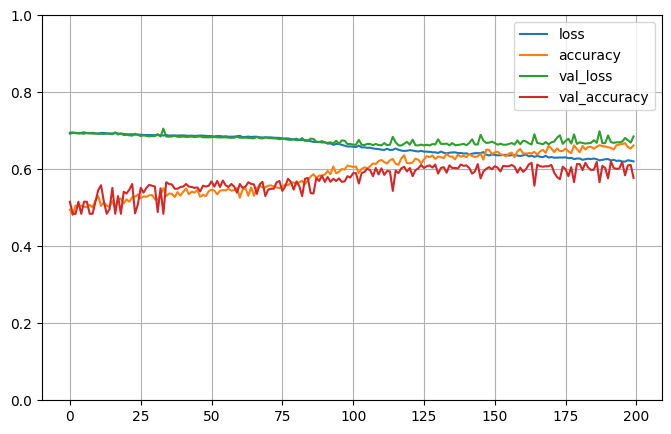


2023-04-01 21:23:18.947666

Testing # 1 4
2023-04-01 21:23:18.947799
2023-04-01 21:23:18.947845
PREDICT
2023-04-01 21:23:18.960675
Test 1:0 459:431 51.57%
Predict 1:0 275:615 30.90%
Test sizes (890, 1025) (890,)
Range of scores: 0.010886671 to 0.9435923
Score threshold 0.5
Confusion matrix
 [[335  96]
 [280 179]]
Normalized matrix
 [[0.37640449 0.10786517]
 [0.31460674 0.2011236 ]]


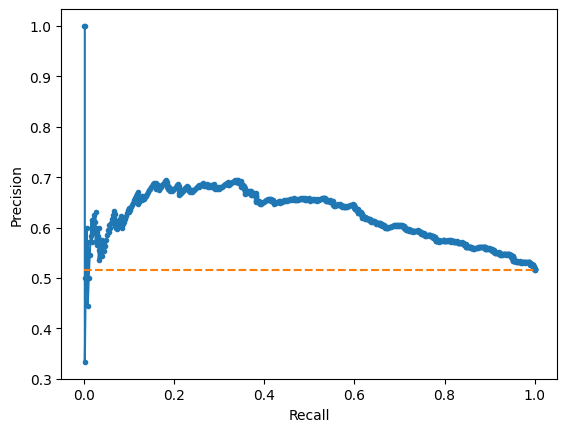

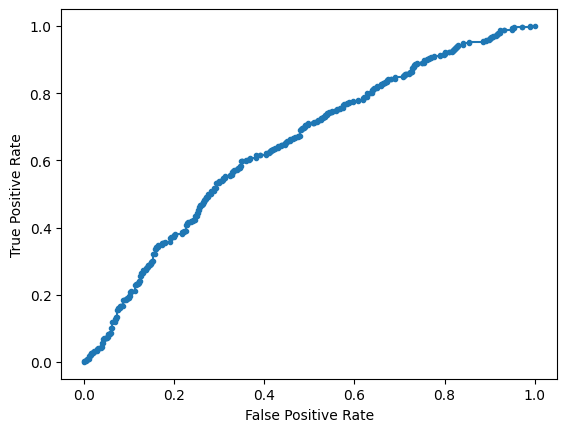

Accuracy: 57.75% Precision: 65.09% Recall: 39.00%
F1: 48.77% MCC: 0.1809
AUPRC: 62.28% AUROC: 64.49%
 accuracy [57.752808988764045]
 precision [65.0909090909091]
 recall [38.99782135076253]
 F1 [48.77384196185287]
 MCC [0.18087654606424075]
 AUPRC [62.28021441903755]
 AUROC [64.49105035156626]
2023-04-01 21:23:19.749236

Training # 1 5
2023-04-01 21:23:19.749447
2023-04-01 21:23:19.749517
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-04-01 21:23:19.838088


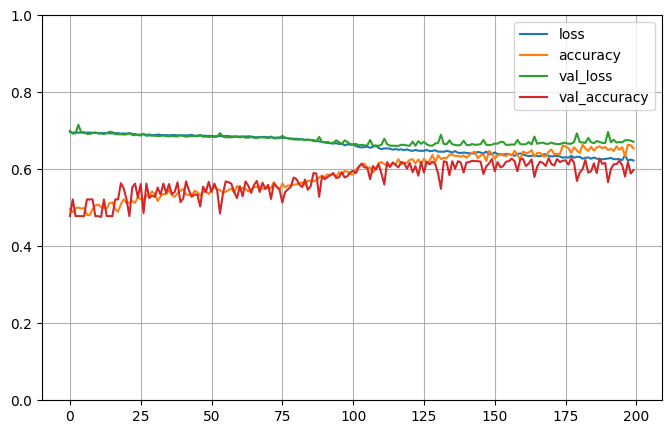


2023-04-01 21:24:42.979747

Testing # 1 5
2023-04-01 21:24:42.979901
2023-04-01 21:24:42.979964
PREDICT
2023-04-01 21:24:42.988785
Test 1:0 457:419 52.17%
Predict 1:0 609:267 69.52%
Test sizes (876, 1025) (876,)
Range of scores: 0.012669768 to 0.97453517
Score threshold 0.5
Confusion matrix
 [[167 252]
 [100 357]]
Normalized matrix
 [[0.19063927 0.28767123]
 [0.11415525 0.40753425]]


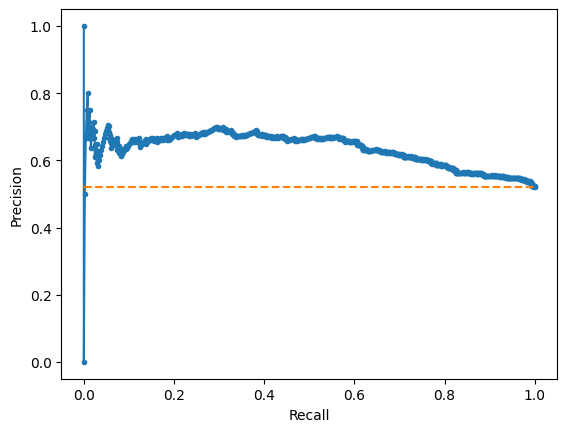

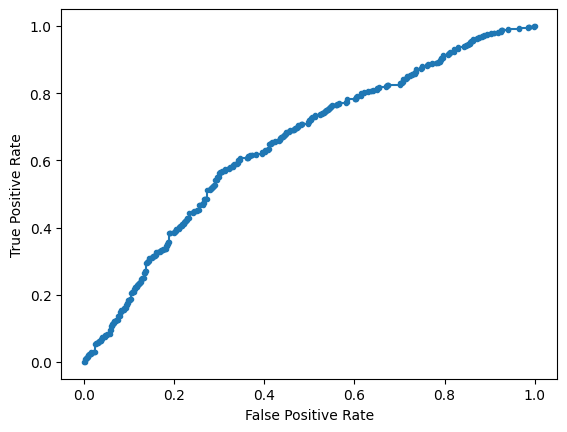

Accuracy: 59.82% Precision: 58.62% Recall: 78.12%
F1: 66.98% MCC: 0.1951
AUPRC: 63.42% AUROC: 64.90%
 accuracy [59.817351598173516]
 precision [58.620689655172406]
 recall [78.11816192560175]
 F1 [66.97936210131333]
 MCC [0.19506028740986214]
 AUPRC [63.416681854535284]
 AUROC [64.90027835369196]
2023-04-01 21:24:43.794214

Training # 2 1
2023-04-01 21:24:43.795455
2023-04-01 21:24:43.795537
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-04-01 21:24:43.881619


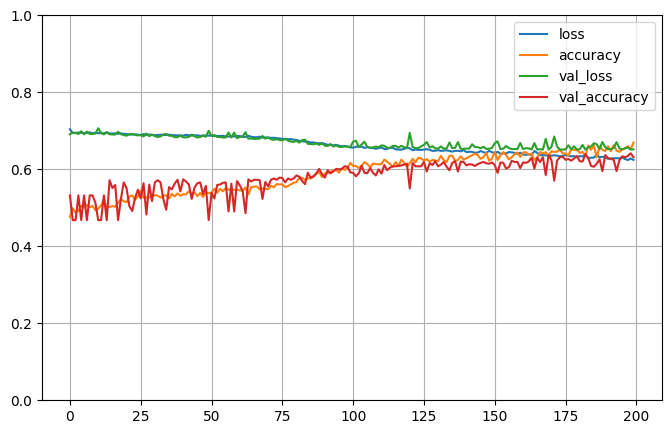


2023-04-01 21:25:59.901112

Testing # 2 1
2023-04-01 21:25:59.903025
2023-04-01 21:25:59.903557
PREDICT
2023-04-01 21:25:59.916038
Test 1:0 472:415 53.21%
Predict 1:0 537:350 60.54%
Test sizes (887, 1025) (887,)
Range of scores: 0.03236471 to 0.9882259
Score threshold 0.5
Confusion matrix
 [[219 196]
 [131 341]]
Normalized matrix
 [[0.24689966 0.22096956]
 [0.14768884 0.38444194]]


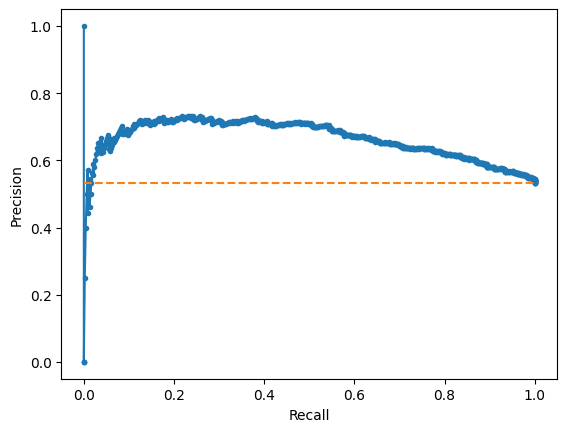

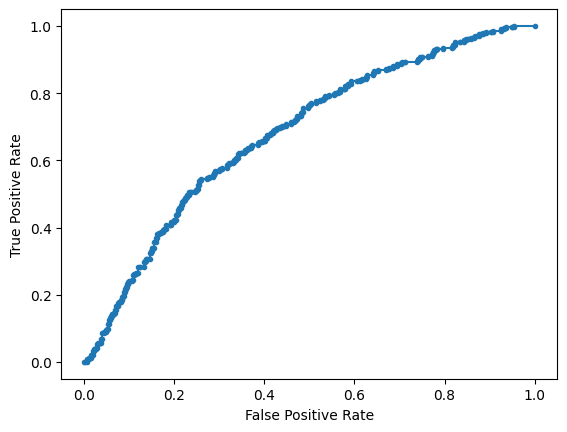

Accuracy: 63.13% Precision: 63.50% Recall: 72.25%
F1: 67.59% MCC: 0.2554
AUPRC: 66.26% AUROC: 67.96%
 accuracy [63.134160090191656]
 precision [63.50093109869647]
 recall [72.2457627118644]
 F1 [67.59167492566898]
 MCC [0.2553915100545843]
 AUPRC [66.26483455195553]
 AUROC [67.95793342862979]
2023-04-01 21:26:01.135935

Training # 2 2
2023-04-01 21:26:01.138205
2023-04-01 21:26:01.138636
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-04-01 21:26:01.245527


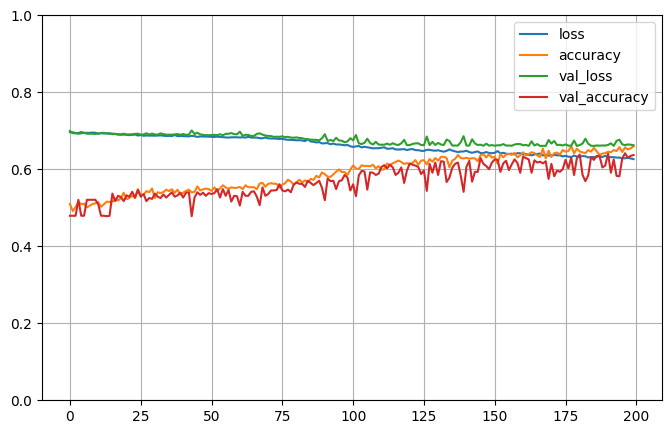


2023-04-01 21:27:18.041327

Testing # 2 2
2023-04-01 21:27:18.042901
2023-04-01 21:27:18.042945
PREDICT
2023-04-01 21:27:18.049415
Test 1:0 452:416 52.07%
Predict 1:0 455:413 52.42%
Test sizes (868, 1025) (868,)
Range of scores: 0.026260346 to 0.9632195
Score threshold 0.5
Confusion matrix
 [[257 159]
 [156 296]]
Normalized matrix
 [[0.29608295 0.18317972]
 [0.1797235  0.34101382]]


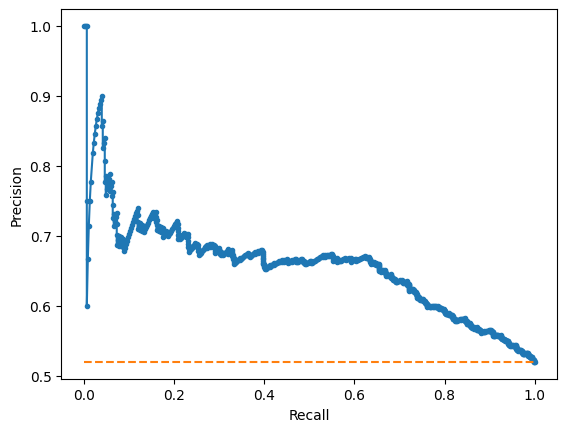

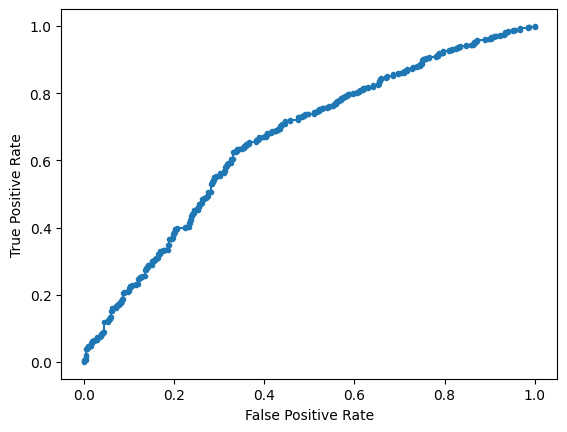

Accuracy: 63.71% Precision: 65.05% Recall: 65.49%
F1: 65.27% MCC: 0.2727
AUPRC: 65.74% AUROC: 66.19%
 accuracy [63.70967741935484]
 precision [65.05494505494505]
 recall [65.48672566371681]
 F1 [65.27012127894157]
 MCC [0.272740585682348]
 AUPRC [65.74288428912381]
 AUROC [66.1876701837985]
2023-04-01 21:27:18.920835

Training # 2 3
2023-04-01 21:27:18.922477
2023-04-01 21:27:18.922549
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-04-01 21:27:18.993309


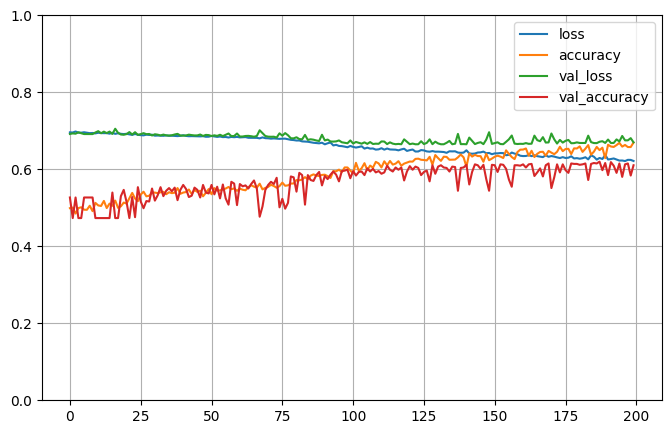


2023-04-01 21:28:42.107213

Testing # 2 3
2023-04-01 21:28:42.107819
2023-04-01 21:28:42.107864
PREDICT
2023-04-01 21:28:42.115254
Test 1:0 453:407 52.67%
Predict 1:0 526:334 61.16%
Test sizes (860, 1025) (860,)
Range of scores: 0.009095117 to 0.95626783
Score threshold 0.5
Confusion matrix
 [[203 204]
 [131 322]]
Normalized matrix
 [[0.23604651 0.2372093 ]
 [0.15232558 0.3744186 ]]


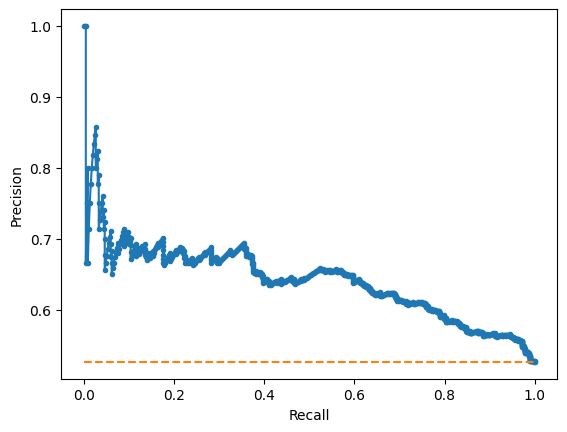

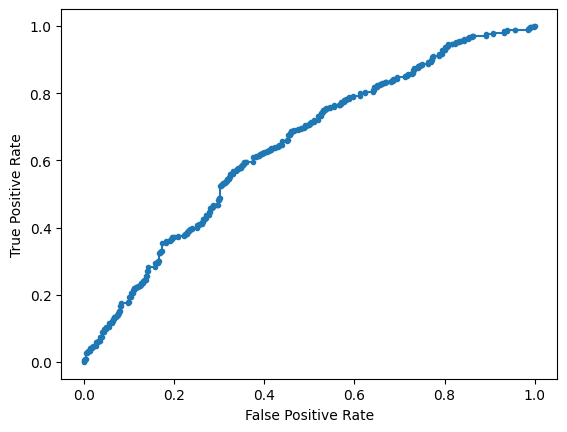

Accuracy: 61.05% Precision: 61.22% Recall: 71.08%
F1: 65.78% MCC: 0.2147
AUPRC: 64.21% AUROC: 64.40%
 accuracy [61.04651162790697]
 precision [61.21673003802282]
 recall [71.08167770419426]
 F1 [65.78140960163431]
 MCC [0.21470748513041804]
 AUPRC [64.20966654473396]
 AUROC [64.39624452869487]
2023-04-01 21:28:42.917950

Training # 2 4
2023-04-01 21:28:42.919145
2023-04-01 21:28:42.919208
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-04-01 21:28:42.994329


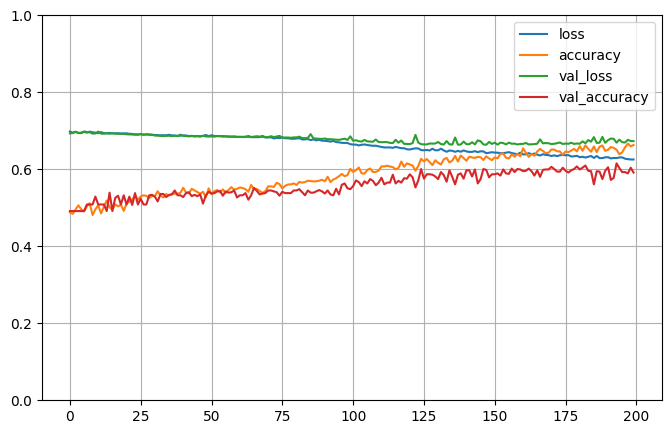


2023-04-01 21:30:06.538303

Testing # 2 4
2023-04-01 21:30:06.538430
2023-04-01 21:30:06.538475
PREDICT
2023-04-01 21:30:06.554429
Test 1:0 432:447 49.15%
Predict 1:0 565:314 64.28%
Test sizes (879, 1025) (879,)
Range of scores: 0.016280225 to 0.9335881
Score threshold 0.5
Confusion matrix
 [[201 246]
 [113 319]]
Normalized matrix
 [[0.22866894 0.27986348]
 [0.12855518 0.3629124 ]]


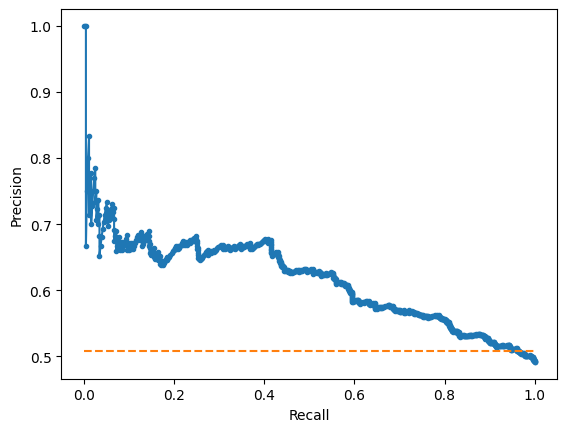

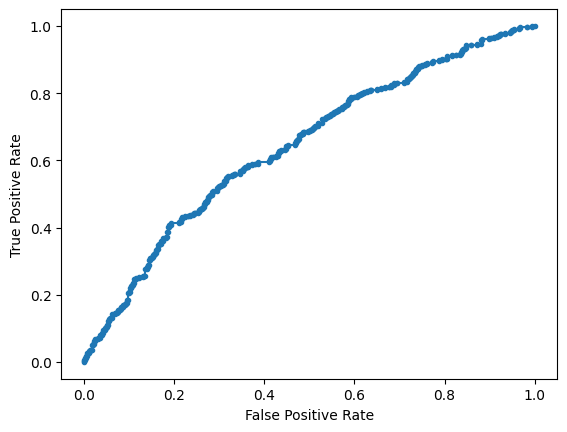

Accuracy: 59.16% Precision: 56.46% Recall: 73.84%
F1: 63.99% MCC: 0.1962
AUPRC: 61.55% AUROC: 64.14%
 accuracy [59.15813424345847]
 precision [56.46017699115045]
 recall [73.8425925925926]
 F1 [63.99197592778335]
 MCC [0.19623348385136216]
 AUPRC [61.5502157373124]
 AUROC [64.14056674123789]
2023-04-01 21:30:07.356675

Training # 2 5
2023-04-01 21:30:07.357729
2023-04-01 21:30:07.357791
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-04-01 21:30:07.431692


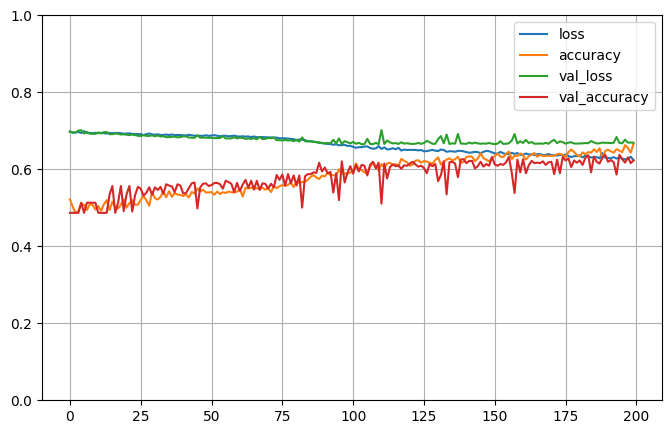


2023-04-01 21:31:30.560965

Testing # 2 5
2023-04-01 21:31:30.561074
2023-04-01 21:31:30.561107
PREDICT
2023-04-01 21:31:30.567632
Test 1:0 449:426 51.31%
Predict 1:0 431:444 49.26%
Test sizes (875, 1025) (875,)
Range of scores: 0.024674106 to 0.9746279
Score threshold 0.5
Confusion matrix
 [[270 156]
 [174 275]]
Normalized matrix
 [[0.30857143 0.17828571]
 [0.19885714 0.31428571]]


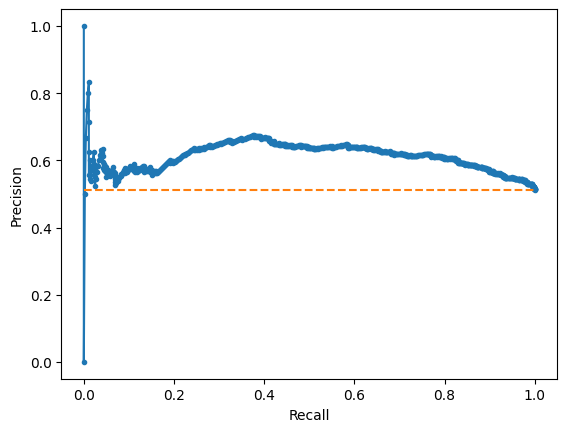

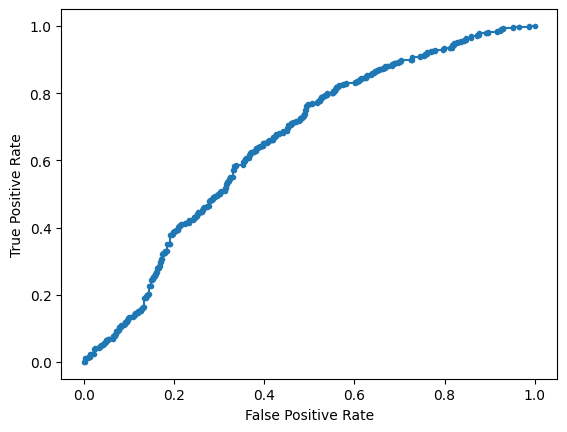

Accuracy: 62.29% Precision: 63.81% Recall: 61.25%
F1: 62.50% MCC: 0.2462
AUPRC: 61.12% AUROC: 65.60%
 accuracy [62.28571428571429]
 precision [63.80510440835266]
 recall [61.24721603563474]
 F1 [62.499999999999986]
 MCC [0.24621705791391327]
 AUPRC [61.12345219768025]
 AUROC [65.59908821899474]
2023-04-01 21:31:31.157626


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 61.24% std 1.96
 precision mean 61.69% std 3.29
 recall mean 68.55% std 12.86
 F1 mean 64.09% std 5.75
 MCC mean 0.23% std 0.03
 AUPRC mean 63.54% std 2.05
 AUROC mean 65.48% std 1.24
 accuracy [[62.643678160919535], [62.66968325791855], [60.18845700824499], [57.752808988764045], [59.817351598173516], [63.134160090191656], [63.70967741935484], [61.04651162790697], [59.15813424345847], [62.28571428571429]]
 precision [[65.21739130434783], [60.0358422939068], [57.878787878787875], [65.0909090909091], [58.620689655172406], [63.50093109869647], [65.05494505494505], [61.21673003802282], [56.46017699115045], [63.80510440835266]]
 recall [[62.227074235807855], [75.7918552036199], [86.42533936651584], [38.99782135076253], [78.11816192560175], [72.2457627118644], [65.48672566371681], [71.08167770419426], [73.8425925925926], [61.24721603563474]]
 F1 [[63.68715083798882], [67.0], [69.32849364791288], [48.77384196185287], [66.97936210131333], [67.59167492566898], [65.27012127894157]